## Problem Description

Toronto, being among the top destination for Indian immigrants, has a lot of scope for Indian Restaurants. We analyze the neighborhoods in Toronto to identify the most profitable area since the success of the restaurant depends on the people who would be visiting the restaurants.

However, keeping in mind the competition, we will try to narrow down to a particular riding. 

The focus would be on the 2 aspects - 

Riding with high number of Indian Population and Riding with a least number of Indian Restaurants currently

## Data Description

The data which has been used along with the sources -  

a) “List of Postal code of Canada: M” (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) wiki page to get all the information about the neighborhoods present in Toronto. This page has the postal code, borough & the name of all the neighborhoods present in Toronto.

b)  “https://cocl.us/Geospatial_data” csv file to get all the geographical coordinates of the neighborhoods.

c) “Demographics of Toronto” (https://en.m.wikipedia.org/wiki/Demographics_of_Toronto#Ethnic_diversity) wiki page to fetch data regarding Indian Population at various neighborhoods.

d) Foursquare API (which gives venues recommendations), to get the details like Venue names, categories, Latitude, Longitude details of existing places to visit.

#### Segmenting and Clustering Neighborhoods in Toronto

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from urllib.request import urlopen

In [4]:
conda install -c anaconda beautifulsoup4

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numpy-base-1.15.4          |   py36h81de0dd_0         4.2 MB  anaconda
    numpy-1.15.4               |   py36h1d66e8a_0          35 KB  anaconda
    beautifulsoup4-4.8.1       |           py36_0         153 KB  anaconda
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    soupsieve-1.9.5            |           py36_0          61 KB  anaconda
    mkl_fft-1.0.6              |   py36h7dd41cf_0         150 KB  anaconda
    certifi-2019.11.28         |           py36_0         156 KB  an

In [5]:
%pip install geopy

     |████████████████████████████████| 102kB 13.2MB/s ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install lxml

     |████████████████████████████████| 5.8MB 3.4MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
print('Libraries imported.')

Libraries imported.


In [8]:
# download data and parse it:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.text, 'html.parser')
table=soup.find('table', attrs={'class':'wikitable sortable'})

#get headers:
headers=table.findAll('th')
for i, head in enumerate(headers): headers[i]=str(headers[i]).replace("<th>","").replace("</th>","").replace("\n","")

#Find all items and skip first one:
rows=table.findAll('tr')
rows=rows[1:len(rows)]

# skip all meta symbols and line feeds between rows:
for i, row in enumerate(rows): rows[i] = str(rows[i]).replace("\n</td></tr>","").replace("<tr>\n<td>","")

# make dataframe, expand rows and drop the old one:
df=pd.DataFrame(rows)
df[headers] = df[0].str.split("</td>\n<td>", n = 2, expand = True) 
df.drop(columns=[0],inplace=True)

# skip not assigned boroughs:
df = df.drop(df[(df.Borough == "Not assigned")].index)
# give "Not assigned" Neighborhoods same name as Borough:
df.Neighborhood.replace("Not assigned", df.Borough, inplace=True)

# copy Borough value to Neighborhood if NaN:
df.Neighborhood.fillna(df.Borough, inplace=True)
# drop duplicate rows:
df=df.drop_duplicates()

# extract titles from columns
df.update(
    df.Neighborhood.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

df.update(
    df.Borough.loc[
        lambda x: x.str.contains('title')
    ].str.extract('title=\"([^\"]*)',expand=False))

# delete Toronto annotation from Neighbourhood:
df.update(
    df.Neighborhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace(", Toronto",""))
df.update(
    df.Neighborhood.loc[
        lambda x: x.str.contains('Toronto')
    ].str.replace("\(Toronto\)",""))

# combine multiple neighborhoods with the same post code
df2 = pd.DataFrame({'Postcode':df.Postcode.unique()})
df2['Borough']=pd.DataFrame(list(set(df['Borough'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=pd.Series(list(set(df['Neighborhood'].loc[df['Postcode'] == x['Postcode']])) for i, x in df2.iterrows())
df2['Neighborhood']=df2['Neighborhood'].apply(lambda x: ', '.join(x))
df2.dtypes

df2.head(12)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Queen's Park (Toronto),Queen's Park
6,M1B,"Scarborough, Toronto","Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [9]:
df2.shape

(103, 3)

### Geocoding

In [10]:
dfll= pd.read_csv("http://cocl.us/Geospatial_data")
dfll.rename(columns={'Postal Code':'Postcode'}, inplace=True)
dfll.set_index("Postcode")
df2.set_index("Postcode")
toronto_data=pd.merge(df2, dfll)
toronto_data.head(12)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494
5,M9A,Queen's Park (Toronto),Queen's Park,43.667856,-79.532242
6,M1B,"Scarborough, Toronto","Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


In [11]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


In [12]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


In [13]:
CLIENT_ID = 'RYVIU3ZI44PMCW4XVH0053XSXEUQ4Y3FM0LS44U2AGS2KULM' # your Foursquare ID
CLIENT_SECRET = 'TFKDCAHI3KWMU0P2Z1PRVYMX1OACUE5JRQZ2B5TE3AZPTU3D' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RYVIU3ZI44PMCW4XVH0053XSXEUQ4Y3FM0LS44U2AGS2KULM
CLIENT_SECRET:TFKDCAHI3KWMU0P2Z1PRVYMX1OACUE5JRQZ2B5TE3AZPTU3D


In [14]:

toronto_data.loc[0, 'Neighborhood']

'Parkwoods'

In [15]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=RYVIU3ZI44PMCW4XVH0053XSXEUQ4Y3FM0LS44U2AGS2KULM&client_secret=TFKDCAHI3KWMU0P2Z1PRVYMX1OACUE5JRQZ2B5TE3AZPTU3D&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e0edc846d8c56001b55ff31'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.757758604500005,
    'lng': -79.32343823984928},
   'sw': {'lat': 43.7487585955, 'lng': -79.33587476015072}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': 

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park
Lawrence Manor, Lawrence Heights
Queen's Park 
Queen's Park 
Malvern, Rouge
Don Mills North
Woodbine Gardens, Parkview Hill
Ryerson, Garden District
Glencairn
Princess Gardens, West Deane Park, Martin Grove, Islington, Cloverdale
Highland Creek , Rouge Hill, Port Union
Don Mills South, Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Markland Wood, Old Burnhamthorpe, Bloordale Gardens, Eringate
Morningside, Guildwood, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Downsview North, Wilson Heights, Bathurst Manor
Thorncliffe Park
Adelaide, Richmond, King
Dovercourt Village, Dufferin
Scarborough Village
Fairview, Oriole, Henry Farm
Northwood Park, York University
East Toronto
Union Station , Harbourfront East, Toronto Islands
Little Portugal, Trinity–Bellwoods
Ionview, Kennedy Park, East Birchmount Park
Bayview Village
CFB Toronto, Downsview East
Riverdale

In [23]:
print(toronto_venues.shape)
toronto_venues.head()

(2222, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [24]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, Richmond, King",100,100,100,100,100,100
Agincourt,4,4,4,4,4,4
"Agincourt North, Steeles East, L'Amoreaux East, Milliken, Ontario",3,3,3,3,3,3
"Alderwood, Long Branch",9,9,9,9,9,9
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
Berczy Park,57,57,57,57,57,57
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CFB Toronto, Downsview East",2,2,2,2,2,2


In [25]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 273 uniques categories.


In [27]:
dfIndian = toronto_venues[toronto_venues['Venue Category'] == 'Indian Restaurant']

In [28]:
print (dfIndian['Neighborhood'].value_counts())

Scarborough Town Centre, Wexford Heights, Dorset Park    2
Thorncliffe Park                                         2
Central Bay Street                                       1
St. James Town                                           1
Riverdale, The Danforth West                             1
Yorkville, The Annex, North Midtown                      1
Davisville                                               1
Union Station , Harbourfront East, Toronto Islands       1
Church and Wellesley                                     1
St. James Town, Cabbagetown                              1
Bedford Park, Lawrence Manor East                        1
Name: Neighborhood, dtype: int64


In [29]:
dfIndian

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
328,St. James Town,43.651494,-79.375418,Bombay Palace,43.651174,-79.372140,Indian Restaurant
553,Central Bay Street,43.657952,-79.387383,Colaba Junction,43.660940,-79.385635,Indian Restaurant
616,Thorncliffe Park,43.705369,-79.349372,Iqbal Kebab & Sweet Centre,43.705923,-79.351521,Indian Restaurant
624,Thorncliffe Park,43.705369,-79.349372,Hakka Garden,43.704578,-79.349770,Indian Restaurant
894,"Union Station , Harbourfront East, Toronto Isl...",43.640816,-79.381752,Indian Roti House,43.639060,-79.385422,Indian Restaurant
1015,"Riverdale, The Danforth West",43.679557,-79.352188,Sher-E-Punjab,43.677308,-79.353066,Indian Restaurant
1338,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,The Copper Chimney,43.736195,-79.420271,Indian Restaurant
1421,"Scarborough Town Centre, Wexford Heights, Dors...",43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant
1425,"Scarborough Town Centre, Wexford Heights, Dors...",43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant
1515,"Yorkville, The Annex, North Midtown",43.672710,-79.405678,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant


In [33]:
dfMerged = pd.merge(dfIndian, toronto_data, on="Neighborhood")

In [70]:
dfMerged

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Postcode,Borough,Latitude,Longitude
0,St. James Town,43.651494,-79.375418,Bombay Palace,43.651174,-79.372140,Indian Restaurant,M5C,Downtown Toronto,43.651494,-79.375418
1,Central Bay Street,43.657952,-79.387383,Colaba Junction,43.660940,-79.385635,Indian Restaurant,M5G,Downtown Toronto,43.657952,-79.387383
2,Thorncliffe Park,43.705369,-79.349372,Iqbal Kebab & Sweet Centre,43.705923,-79.351521,Indian Restaurant,M4H,East York,43.705369,-79.349372
3,Thorncliffe Park,43.705369,-79.349372,Hakka Garden,43.704578,-79.349770,Indian Restaurant,M4H,East York,43.705369,-79.349372
4,"Union Station , Harbourfront East, Toronto Isl...",43.640816,-79.381752,Indian Roti House,43.639060,-79.385422,Indian Restaurant,M5J,Downtown Toronto,43.640816,-79.381752
5,"Riverdale, The Danforth West",43.679557,-79.352188,Sher-E-Punjab,43.677308,-79.353066,Indian Restaurant,M4K,East Toronto,43.679557,-79.352188
6,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,The Copper Chimney,43.736195,-79.420271,Indian Restaurant,M5M,North York,43.733283,-79.419750
7,"Scarborough Town Centre, Wexford Heights, Dors...",43.757410,-79.273304,Kairali,43.754915,-79.276945,Indian Restaurant,M1P,"Scarborough, Toronto",43.757410,-79.273304
8,"Scarborough Town Centre, Wexford Heights, Dors...",43.757410,-79.273304,Karaikudi Chettinad South Indian Restaurant,43.756042,-79.276276,Indian Restaurant,M1P,"Scarborough, Toronto",43.757410,-79.273304
9,"Yorkville, The Annex, North Midtown",43.672710,-79.405678,Roti Cuisine of India,43.674618,-79.408249,Indian Restaurant,M5R,Central Toronto,43.672710,-79.405678


In [36]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(dfMerged['Latitude'], dfMerged['Longitude'], dfMerged['Borough'], dfMerged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [39]:
!conda install -c conda-forge wikipedia --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - wikipedia


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    wikipedia-1.4.0            |             py_2          13 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         162 KB

The following NEW packages will be INSTALLED:

    wikipedia: 1.4.0-py_2        conda-forge

The following packages will be UPDATED:

    certifi:   2019.11.28-py36_0 anaconda    --> 2019.11.28-py36_0 conda-forge

The following packages

In [40]:
#overall population distribution 
import wikipedia as wp
html = wp.page("Demographics of Toronto").html().encode("UTF-8")

In [45]:
TEY_population_df = pd.read_html(html, header = 0)[13]
TEY_population_df = TEY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %',
                                                     '%.8':'Ethnic Origin 9 in %'})
TEY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Spadina-Fort York,114315,English,16.4,Chinese,16.0,Irish,14.6,Canadian,14.0,Scottish,13.2,French,7.70,German,7.6,NaN,NaN,NaN,NaN
1,Beaches-East York,108435,English,24.2,Irish,19.9,Canadian,19.7,Scottish,18.9,French,8.7,German,8.40,NaN,NaN,NaN,NaN,NaN,NaN
2,Davenport,107395,Portuguese,22.7,English,13.6,Canadian,12.8,Irish,11.5,Italian,11.1,Scottish,11.00,NaN,NaN,NaN,NaN,NaN,NaN
3,Parkdale-High Park,106445,English,22.3,Irish,20.0,Scottish,18.7,Canadian,16.1,German,9.8,French,8.88,Polish,8.5,NaN,NaN,NaN,NaN
4,Toronto-Danforth,105395,English,22.9,Irish,19.5,Scottish,18.7,Canadian,18.4,Chinese,13.8,French,8.86,German,8.8,Greek,7.3,NaN,NaN
5,Toronto-St. Paul's,104940,English,18.5,Canadian,16.1,Irish,15.2,Scottish,14.8,Polish,10.3,German,7.90,Russian,7.7,Italian,7.3,French,7.2
6,University-Rosedale,100520,English,20.6,Irish,16.6,Scottish,16.3,Canadian,15.2,Chinese,14.7,German,8.70,French,7.7,Italian,7.4,NaN,NaN
7,Toronto Centre,99590,English,15.7,Canadian,13.7,Irish,13.4,Scottish,12.6,Chinese,12.5,French,7.20,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#NORTH YORK population distribution by ethnicity 
North_population_df = pd.read_html(html, header = 0)[14]
North_population_df = North_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
North_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.5,Irish,9.2,Russian,8.4
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN


In [47]:
#SCARBOROUGH population distribution by ethnicity 
Scar_population_df = pd.read_html(html, header = 0)[15]
Scar_population_df = Scar_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
Scar_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN
1,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN
2,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0
4,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN
5,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#ETOBICOKE & YORK population distribution by ethnicity 
ETY_population_df = pd.read_html(html, header = 0)[16]
ETY_population_df = ETY_population_df.rename(columns={'%':'Ethnic Origin 1 in %', 
                                                      '%.1':'Ethnic Origin 2 in %',
                                                     '%.2':'Ethnic Origin 3 in %',
                                                     '%.3':'Ethnic Origin 4 in %',
                                                     '%.4':'Ethnic Origin 5 in %',
                                                     '%.5':'Ethnic Origin 6 in %',
                                                     '%.6':'Ethnic Origin 7 in %',
                                                     '%.7':'Ethnic Origin 8 in %'})
ETY_population_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %
0,Etobicoke-Lakeshore,127520,English,17.1,Canadian,15.9,Irish,14.4,Scottish,13.5,Polish,9.2,Italian,9.1,Ukrainian,7.6,German,7.1
1,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Etobicoke Centre,116055,Italian,15.1,English,14.3,Canadian,12.1,Irish,10.8,Scottish,10.4,Ukrainian,8.1,Polish,7.4,NaN,NaN
3,York South-Weston,115130,Portuguese,14.5,Italian,12.8,Canadian,8.7,Jamaican,8.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
ET = ETY_population_df.append(TEY_population_df,sort=True).reset_index()
ET.drop('index',axis=1,inplace=True)
SN = North_population_df.append(Scar_population_df,sort=True).reset_index()
SN.drop('index',axis=1,inplace=True)
pop_ethnic_df = SN.append(ET,sort=True).reset_index()
pop_ethnic_df.drop('index',axis=1,inplace=True)
pop_ethnic_df = pop_ethnic_df[['Riding', 'Population','Ethnic Origin #1', 'Ethnic Origin 1 in %','Ethnic Origin #2', 'Ethnic Origin 2 in %',
                               'Ethnic Origin #3','Ethnic Origin 3 in %','Ethnic Origin #4', 'Ethnic Origin 4 in %','Ethnic Origin #5','Ethnic Origin 5 in %', 
                               'Ethnic Origin #6','Ethnic Origin 6 in %','Ethnic Origin #7', 'Ethnic Origin 7 in %','Ethnic Origin #8', 'Ethnic Origin 8 in %',
                               'Ethnic Origin #9','Ethnic Origin 9 in %',
                              ]]
pop_ethnic_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Willowdale,117405,Chinese,25.9,Iranian,12.1,Korean,10.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eglinton-Lawrence,112925,Canadian,14.7,English,12.6,Polish,12.0,Filipino,11.0,Scottish,9.7,Italian,9.50,Irish,9.2,Russian,8.4,NaN,NaN
2,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,York Centre,103760,Filipino,17.0,Italian,13.4,Russian,9.5,Canadian,8.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Don Valley West,101790,English,19.2,Canadian,15.1,Scottish,14.9,Irish,14.2,Chinese,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.00,Filipino,7.8,NaN,NaN,NaN,NaN
7,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.00,NaN,NaN,NaN,NaN,NaN,NaN
8,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.20,Chinese,7.2,NaN,NaN,NaN,NaN
9,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
#Filtering the riding with Indian ethnic crowd
temp = pop_ethnic_df.loc[(pop_ethnic_df['Ethnic Origin #1'] == 'East Indian')| 
                                      (pop_ethnic_df['Ethnic Origin #2'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #3'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #4'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #5'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #6'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #7'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #8'] == 'East Indian')|
                                      (pop_ethnic_df['Ethnic Origin #9'] == 'East Indian')]
pop_indian_df = pd.DataFrame(temp).reset_index()
pop_indian_df.drop('index',axis=1,inplace=True)

pop_indian_df

,Riding,Population,Ethnic Origin #1,Ethnic Origin 1 in %,Ethnic Origin #2,Ethnic Origin 2 in %,Ethnic Origin #3,Ethnic Origin 3 in %,Ethnic Origin #4,Ethnic Origin 4 in %,Ethnic Origin #5,Ethnic Origin 5 in %,Ethnic Origin #6,Ethnic Origin 6 in %,Ethnic Origin #7,Ethnic Origin 7 in %,Ethnic Origin #8,Ethnic Origin 8 in %,Ethnic Origin #9,Ethnic Origin 9 in %
0,Don Valley North,109060,Chinese,32.4,East Indian,7.3,Iranian,7.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Humber River-Black Creek,107725,Italian,12.8,East Indian,9.2,Jamaican,8.5,Vietnamese,8.0,Canadian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Don Valley East,93170,East Indian,10.6,Canadian,10.4,English,10.1,Chinese,8.9,Irish,8.1,Scottish,8.0,Filipino,7.8,NaN,NaN,NaN,NaN
3,Scarborough Centre,110450,Filipino,13.1,East Indian,12.2,Canadian,11.2,Chinese,10.7,English,7.8,Sri Lankan,7.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Scarborough Southwest,108295,Canadian,16.2,English,14.3,Irish,11.5,Scottish,10.9,Filipino,9.5,East Indian,8.2,Chinese,7.2,NaN,NaN,NaN,NaN
5,Scarborough-Agincourt,104225,Chinese,47.0,East Indian,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Scarborough-Rouge Park,101445,East Indian,16.7,Canadian,11.8,Sri Lankan,11.1,English,9.8,Filipino,9.3,Jamaican,8.4,Scottish,7.2,Irish,7.0,NaN,NaN
7,Scarborough-Guildwood,101115,East Indian,18.0,Canadian,11.6,English,9.7,Filipino,8.5,Sri Lankan,7.8,Chinese,7.1,Scottish,7.0,NaN,NaN,NaN,NaN
8,Scarborough North,97610,Chinese,46.6,East Indian,11.8,Sri Lankan,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Etobicoke North,116960,East Indian,22.2,Canadian,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
#retaining only Indian ethnic percentage & the neighborhood name 
columns_list = pop_indian_df.columns.to_list()
pop_indian_DF_with_percent = pd.DataFrame()
#removing Riding & Population from the column names list
del columns_list[0]
del columns_list[0]


for i in range(0,pop_indian_df.shape[0]):
    for j in columns_list:
        print(j)
        if pop_indian_df.at[i, j] == 'East Indian':
            k = columns_list.index(j) + 1
            percent_col = columns_list[k]
            pop_indian_DF_with_percent = pop_indian_DF_with_percent.append({'Riding':pop_indian_df.at[i, 'Riding'], 'Population':pop_indian_df.at[i, 'Population']
                                                                           , 'Ethnicity': pop_indian_df.at[i, j], 'Percentage': pop_indian_df.at[i, percent_col]},ignore_index=True)

pop_indian_DF_with_percent

Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origin #9
Ethnic Origin 9 in %
Ethnic Origin #1
Ethnic Origin 1 in %
Ethnic Origin #2
Ethnic Origin 2 in %
Ethnic Origin #3
Ethnic Origin 3 in %
Ethnic Origin #4
Ethnic Origin 4 in %
Ethnic Origin #5
Ethnic Origin 5 in %
Ethnic Origin #6
Ethnic Origin 6 in %
Ethnic Origin #7
Ethnic Origin 7 in %
Ethnic Origin #8
Ethnic Origin 8 in %
Ethnic Origi

,Ethnicity,Percentage,Population,Riding
0,East Indian,7.3,109060.0,Don Valley North
1,East Indian,9.2,107725.0,Humber River-Black Creek
2,East Indian,10.6,93170.0,Don Valley East
3,East Indian,12.2,110450.0,Scarborough Centre
4,East Indian,8.2,108295.0,Scarborough Southwest
5,East Indian,7.4,104225.0,Scarborough-Agincourt
6,East Indian,16.7,101445.0,Scarborough-Rouge Park
7,East Indian,18.0,101115.0,Scarborough-Guildwood
8,East Indian,11.8,97610.0,Scarborough North
9,East Indian,22.2,116960.0,Etobicoke North


In [52]:
pop_indian_DF_with_percent['Indian Population'] = (pop_indian_DF_with_percent['Percentage'] * pop_indian_DF_with_percent['Population'])/100
pop_indian_DF_with_percent.drop(columns={'Percentage','Population','Ethnicity'},axis=1, inplace =True)
pop_indian_DF_with_percent.drop_duplicates(keep='first',inplace=True) 
pop_indian_DF_with_percent

,Riding,Indian Population
0,Don Valley North,7961.380
1,Humber River-Black Creek,9910.700
2,Don Valley East,9876.020
3,Scarborough Centre,13474.900
4,Scarborough Southwest,8880.190
5,Scarborough-Agincourt,7712.650
6,Scarborough-Rouge Park,16941.315
7,Scarborough-Guildwood,18200.700
8,Scarborough North,11517.980
9,Etobicoke North,25965.120


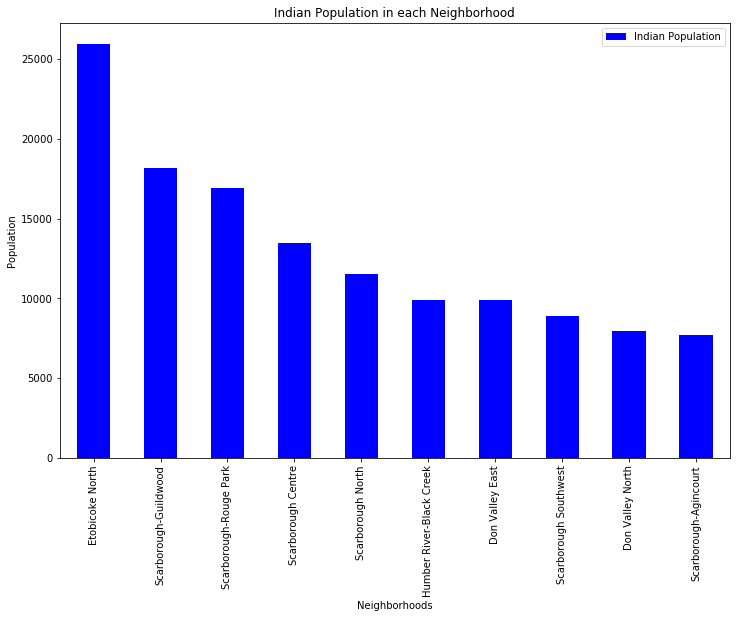

In [54]:
bar_graph = pop_indian_DF_with_percent.sort_values(by='Indian Population', ascending=False)
bar_graph.plot(kind='bar',x='Riding', y='Indian Population',figsize=(12,8), color='blue')
plt.title("Indian Population in each Neighborhood")
plt.xlabel("Neighborhoods")
plt.ylabel("Population")
plt.show()

In [55]:
#Altering the list to match the wikipedia page so we can retrieve the neighborhoods present in those Ridings
riding_list = pop_indian_DF_with_percent['Riding'].to_list()
riding_list[riding_list.index('Scarborough Centre')] = 'Scarborough Centre (electoral district)'
riding_list[riding_list.index('Scarborough North')] = 'Scarborough North (electoral district)'
riding_list

['Don Valley North',
 'Humber River-Black Creek',
 'Don Valley East',
 'Scarborough Centre (electoral district)',
 'Scarborough Southwest',
 'Scarborough-Agincourt',
 'Scarborough-Rouge Park',
 'Scarborough-Guildwood',
 'Scarborough North (electoral district)',
 'Etobicoke North']

In [60]:
#Scraping wiki page to get the neighborhoods of ech Ridings
import wikipedia

Riding_neighborhood_df = pd.DataFrame()

for item in riding_list:
    section = wikipedia.WikipediaPage(item).section('Geography')
    start = section.index('neighbourhoods of') + 17
    stop = section.index('.',start)
    Riding_neighborhood_df = Riding_neighborhood_df.append({'Riding':item, 'Neighborhood':section[start:stop]},ignore_index=True)
    

Riding_neighborhood_df = Riding_neighborhood_df[['Riding','Neighborhood']]
Riding_neighborhood_df

,Riding,Neighborhood
0,Don Valley North,"Henry Farm, Bayview Village, Bayview Woods-St..."
1,Humber River-Black Creek,"Humber Summit, Humbermede, Humberlea, York Un..."
2,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,Scarborough Centre (electoral district),Scarborough City Centre (west of McCowan Road...
4,Scarborough Southwest,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
5,Scarborough-Agincourt,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."
6,Scarborough-Rouge Park,"Morningside Heights, Rouge, Port Union, West ..."
7,Scarborough-Guildwood,"Guildwood, West Hill (west of Morningside Ave..."
8,Scarborough North (electoral district),"Agincourt (east of Midland Avenue), Milliken ..."
9,Etobicoke North,"The Elms, Humberwood, Kingsview Village, This..."


In [61]:
dfRidingNeighMerged = pd.merge(Riding_neighborhood_df, pop_indian_DF_with_percent, on="Riding")

In [62]:
dfRidingNeighMerged

,Riding,Neighborhood,Indian Population
0,Don Valley North,"Henry Farm, Bayview Village, Bayview Woods-St...",7961.380
1,Humber River-Black Creek,"Humber Summit, Humbermede, Humberlea, York Un...",9910.700
2,Don Valley East,"Flemingdon Park, Don Mills, Graydon Hall, Par...",9876.020
3,Scarborough Southwest,"Birch Cliff, Oakridge, Cliffside, Kennedy Par...",8880.190
4,Scarborough-Agincourt,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ...",7712.650
5,Scarborough-Rouge Park,"Morningside Heights, Rouge, Port Union, West ...",16941.315
6,Scarborough-Guildwood,"Guildwood, West Hill (west of Morningside Ave...",18200.700
7,Etobicoke North,"The Elms, Humberwood, Kingsview Village, This...",25965.120


In [72]:
#Merging the pop_indian_DF_with_percent dataframe containing population information with the Riding_neighborhood_df dataframe.

Neigh_pop = pd.merge(pop_indian_DF_with_percent, Riding_neighborhood_df, on='Riding')

In [73]:
Neigh_pop.sort_values(by='Indian Population', ascending=False)

,Riding,Indian Population,Neighborhood
7,Etobicoke North,25965.120,"The Elms, Humberwood, Kingsview Village, This..."
6,Scarborough-Guildwood,18200.700,"Guildwood, West Hill (west of Morningside Ave..."
5,Scarborough-Rouge Park,16941.315,"Morningside Heights, Rouge, Port Union, West ..."
1,Humber River-Black Creek,9910.700,"Humber Summit, Humbermede, Humberlea, York Un..."
2,Don Valley East,9876.020,"Flemingdon Park, Don Mills, Graydon Hall, Par..."
3,Scarborough Southwest,8880.190,"Birch Cliff, Oakridge, Cliffside, Kennedy Par..."
0,Don Valley North,7961.380,"Henry Farm, Bayview Village, Bayview Woods-St..."
4,Scarborough-Agincourt,7712.650,"Steeles, L'Amoreaux, Tam O'Shanter-Sullivan, ..."


### Conclusion

#### Etobicoke North has the highest Indian Population in Toronto but no Indian Restaurtant as per the Foursquare data. Hence, opening an Indian Restaurant in the Etobicoke North riding will make a lot of sense.